# Gitcoin graph-based communities

On this notebook, we will explore the graph for Gitcoin's collaborator network. We are specifically interested in visualizing the following objects:

1. The outer product of the collaborator-grants space.
2. The time series of how much communities there are on Gitcoin through the Greedy Modularity algorithm
3. The contribution graph segmented by 5 fluid communities.
4. The subgraphs for three distinct communities, specifically, the ones which neighbors:
    1. the cadCAD grant
    2. the MetaGame grant
    3. the DAppChaser grant

## Load data from pickle file
The model results have been pre-computed as a pickle file to save time for the user. For analyzing the network, there is no need to rerun the cadCAD model to conver the raw .csv or excel data to the pickled file. If the user would like to do so, they could by running the following:

```
python run_simulation.py
```

**Note:** The simulation is rather large, and may take several minutes to run, depending on your computer's RAM and CPU.

In [1]:
# %load_ext autotime
import matplotlib.pyplot as plt
from collections import defaultdict
from model.parts.utils import *
import networkx as nx
import netwulf as nw
from networkx import community
import plotly.express as px
import numpy as np
import pandas as pd
import cloudpickle
import inequality_coefficients as ineq
from env_config import PICKLE_PATH
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from colormap import rgb2hex

import plotly.io as pio


In [2]:
# This used to make the experiment reproducible.
# Change it if you want to have different random numbers
SEED = 5
pio.renderers.default = "jupyterlab"

# Default visualization parameters for the network plots
NETWORK_VIZ_CONFIG= {'node_fill_color': '#79aaa0',
                     'node_size': 25,
                     'zoom': 0.7,
                     'gravity': 0.12,
                     'charge': -39,
                     'link_width': 1.1
                    }

In [3]:
# Load the data generated by the cadCAD simulation
with open(PICKLE_PATH, 'rb') as fid:
    result = cloudpickle.load(fid)

## Network Analysis

### Outer product across contributor-pairs for the top 5 grants in terms of contribution amount

In [4]:
# Get the last graph
last_state = result.iloc[-1]

# Sum all the contributions for each contributor-grant pair
contributions_totals = (pd.DataFrame(last_state.contributions)
                          .groupby(['contributor', 'grant'])
                          .amount
                          .sum()
                          .pipe(pd.DataFrame)
                          )

#### Cluster map for the collaboration-grant outer product

/home/danlessa/.miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



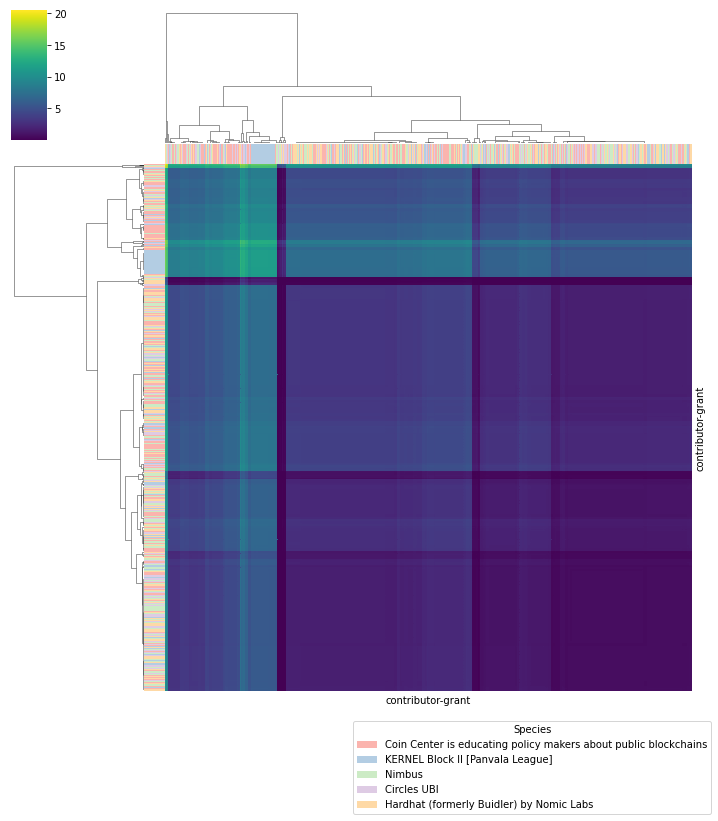

In [5]:
# Filter out the top 5 grants with most contributions
top_grants = contributions_totals.groupby('grant').sum().sort_values('amount').tail(5)
x = contributions_totals.loc[(slice(None), top_grants.index), :]

# Get the outer product on the contributions totals vector
# Thanks @cs95
# https://stackoverflow.com/questions/47912611/compute-matrix-of-outer-operations-on-pandas-series
y = np.array(x.amount.tolist())
outer_df = pd.DataFrame(np.outer(y, y.T), index=x.index, columns=x.index)
outer_df = np.log(outer_df + 1)

# Plot a clustermap
grants_index = outer_df.index.get_level_values(1)
rgb_values = sns.color_palette("Pastel1", len(grants_index.unique()))
lut = dict(zip(grants_index.unique(), rgb_values))
row_colors = grants_index.map(lut)

sns.clustermap(outer_df,
               cmap='viridis',
               row_colors=row_colors,
               col_colors=row_colors,
               xticklabels=False,
               yticklabels=False)

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Species',
           bbox_to_anchor=(1, 0), bbox_transform=plt.gcf().transFigure)
plt.show()

#### Cluster map for the aggregated grants

/home/danlessa/.miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:3889: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



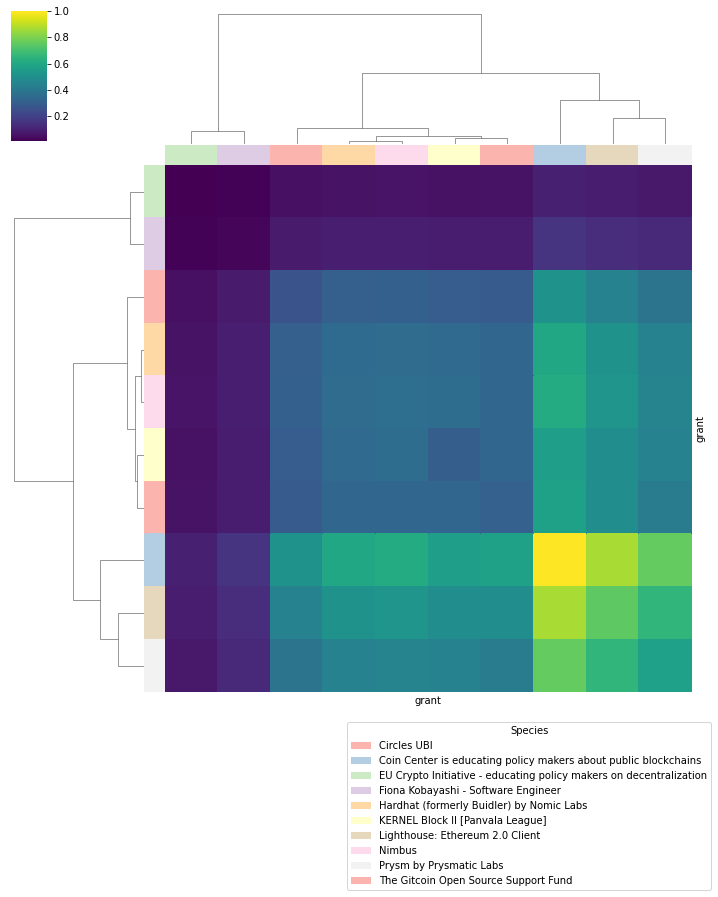

In [6]:
# Filter out the top 10 grants with most contributions
top_grants = contributions_totals.groupby('grant').sum().sort_values('amount').tail(10)
x = contributions_totals.loc[(slice(None), top_grants.index), :]

# Get the outer product on the contributions totals vector
# Thanks @cs95 - https://stackoverflow.com/questions/47912611/compute-matrix-of-outer-operations-on-pandas-series
y = np.array(x.amount.tolist())
outer_df = np.log(pd.DataFrame(np.outer(y, y.T), index=x.index, columns=x.index) + 1)

outer_df = (outer_df.reset_index()
                    .groupby('grant')
                    .sum()
                    .T
                    .groupby('grant')
                    .sum()
                    .pipe(lambda df: df / df.max().max())
           )

# Plot a clustermap
grants_index = outer_df.index
rgb_values = sns.color_palette("Pastel1", len(grants_index.unique()))
lut = dict(zip(grants_index.unique(), rgb_values))
row_colors = grants_index.map(lut)

g = sns.clustermap(outer_df,
                   cmap='viridis',
                   row_colors=row_colors,
                   col_colors=row_colors,
                   xticklabels=False,
                   yticklabels=False)
                   
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45) # For x axis

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Species',
           bbox_to_anchor=(1, 0), bbox_transform=plt.gcf().transFigure)
plt.show()


### Gitcoin Communities


#### Growth of detected communities over time

In [4]:
def total_amount(G: nx.Graph,
                 node: str) -> float:
    """
    Get the total amount in USDT of contribution
    for a given node (grant or contributor)
    """
    # Get all the graph edges associated with the node
    node_edges = G.edges([node])
    
    # Sum all amounts contained in the edges that contains the node
    total_amount = sum(G.edges[edge]['amount']
                       for edge
                       in node_edges)
    
    # Return it
    return total_amount

def contributions_to_graph(contrib_row: list) -> nx.Graph:
    """
    Convert a contributions row from the cadCAD results DataFrame
    into a NetworkX graph.
    """
    # Make sure that we have data
    if len(contrib_row) > 0:
        
        # Load data
        c_df = pd.DataFrame(contrib_row)
        
        # Parse the contributions into a NetworkX graph
        G = nx.from_pandas_edgelist(c_df,
                                    source='contributor',
                                    target='grant',
                                    edge_attr=True)
        
        # Get unique grants and contributors
        unique_grants = c_df.grant.unique()
        unique_contributors = c_df.contributor.unique()
        
        # Associate the 'type' and 'total_amount' attributes for grants and contributors
        grant_node_type = {el: {'type': 'grant',
                                'total_amount': total_amount(G, el)} 
                           for el in unique_grants}
        contrib_node_type = {el: {'type': 'contributor',
                                  'total_amount': total_amount(G, el)} 
                             for el in unique_contributors}
        node_type = {**grant_node_type, **contrib_node_type}    
        
        nx.set_node_attributes(G, node_type)
        
        # Return the graph
        return G
    else:
        return None

# Generate a time series of NetworkX graphs
graphs = result.contributions[1:100].map(contributions_to_graph)

In [5]:
# Function for counting the total detected communities in a graph
community_count = lambda x: len(community.greedy_modularity_communities(x))

# Count it for all graphs that we have
output = {}
for i, G in enumerate(tqdm(graphs)):
    output[i + 1] = community_count(G) 

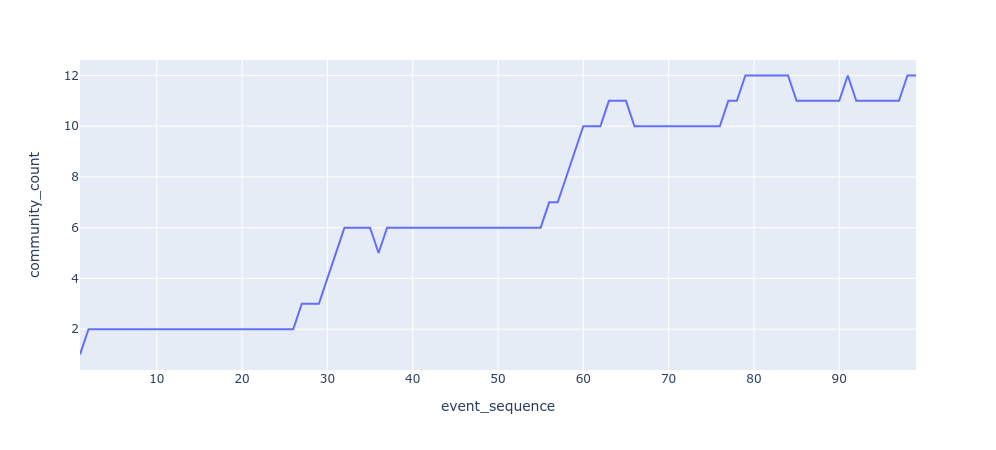

In [6]:
# Visualize the time series of the community count

# Parse and clean the output from the last cell
s = pd.Series(output)
s.name = 'community_count'
s.index.name = 'event_sequence'

# Visualize it
fig_df = s.reset_index()
px.line(fig_df,
        x='event_sequence',
        y='community_count')

#### Fluid Communities

##### Preparation

In [7]:
# Get the last graph
G = contributions_to_graph(result.iloc[-1].contributions)

# Set the sizes and colors
for node, data in tqdm(G.nodes(data=True)):
    data['group'] = data['type']
    data['size'] = np.sqrt(data['total_amount'])

# Print the content of the cadCAD node
G.nodes['cadCAD: Computer Aided Design for Complex Systems']

{'type': 'grant',
 'total_amount': 679.9029932970185,
 'group': 'grant',
 'size': 26.074949535847974}

In [8]:
# Get the largest connected component, this is need for the fluid communities algorithm
giant_component = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(giant_component[0])

# Get a list of list of nodes.
communities = list(community.asyn_fluidc(G0, 5, seed=SEED))

##### Graph visualization, colored by community

In [9]:
# Thanks!
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python

# Map categorical colors. Optional
N = len(communities)
color_labels = range(N)
rgb_values = sns.color_palette("Set2", N)
color_map = dict(zip(color_labels, rgb_values))
color_map = {key: rgb2hex(*[int(255 * i) for i in tup])
             for (key, tup) in color_map.items()}

# Associate colors with the node community
attr_map = {}
for i, comm in enumerate(communities):
    community_map = {node: {'group': color_map[i]}
                     for node in comm}
    attr_map = {**attr_map, **community_map}
nx.set_node_attributes(G, attr_map)

# Plot it
#nw.visualize(G, config=NETWORK_VIZ_CONFIG)

##### Graph visualization, colored by type

In [10]:
# Thanks!
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python

# Map categorical colors. Optional
N = 2
color_labels = range(N)
rgb_values = sns.color_palette("Set2", N)
color_map = dict(zip(color_labels, rgb_values))
color_map = {key: rgb2hex(*[int(255 * i) for i in tup])
             for (key, tup) in color_map.items()}

# Associate colors with the node type
node_attr = {}
for i, typ in enumerate(['grant', 'contributor']):
    type_attr = {node: {'group': color_map[i]}
                 for (node, d) in G.nodes(data=True)
                 if d['type'] == typ}
    node_attr = {**node_attr, **type_attr}
nx.set_node_attributes(G, node_attr)

# Plot it
#nw.visualize(G, config=NETWORK_VIZ_CONFIG)

##### Prepare community subgraph visualizations

In [11]:
def plot_community(G0: nx.Graph,
                   communities: list,
                   community_label: str):
    """
    Visualize a community subgraph.
    """
    # Get a generator for finding the community
    # on which the `community_label` is located.
    # Returns `None` if not found.
    generator = (g
                 for g in communities
                 if community_label in g)

    # Find the first instance where the conditions is valid
    community_nodes = next(generator, None)

    if community_nodes is None:
        print(f"Community f{community_label} was not detected in the giant component")
        return None
    else:
        subgraph = G0.subgraph(community_nodes)
        
        # Number of grants on the subgraph
        N_grants = sum(1 
                       for label, node 
                       in subgraph.nodes(data=True) 
                       if node['type'] == 'grant')
        
        # Number of contributors on the subgraph
        N_contributors = sum(1 
                             for label, node 
                             in subgraph.nodes(data=True) 
                             if node['type'] == 'contributor')
        
        # Total amount in USDT on the subgraph
        subgraph_amount = sum(subgraph.edges[edge]['amount'] 
                              for edge 
                              in subgraph.edges())
        
        # Total amount per grant on the subgraph
        grant_amounts = {label: node['total_amount']
                         for (label, node) in subgraph.nodes(data=True)
                         if node['type'] == 'grant'}
        
        # Top 5 grants on the subgraph
        top_5_grants = sorted(grant_amounts.items(),
                              key=lambda it: it[1])[-5:]
        
        # Print everything
        print(f"Total grants: {N_grants}")
        print(f"Total collaborators: {N_contributors}")
        print(f"Total USD value inside the subgraph: {subgraph_amount:,.2f} USD")
        print("Top 5 grants")
        print("---")
        for (grant, amount) in top_5_grants[::-1]:
            print(f"{grant}: {amount:,.2f} USD")
        
        # Visualize the subgraph
        return nw.visualize(subgraph, config=NETWORK_VIZ_CONFIG)

##### cadCAD: Computer Aided Design for Complex System

In [12]:
plot_community(G0, 
               communities, 
               'cadCAD: Computer Aided Design for Complex Systems')

Total grants: 110
Total collaborators: 888
Total USD value inside the subgraph: 41,047.76 USD
Top 5 grants
---
The Gitcoin Open Source Support Fund: 10,333.02 USD
Commons Stack Community Fund - Panvala League: 2,628.53 USD
Wallkanda: 2,510.39 USD
Autonio: 2,500.89 USD
DistributedTown: 2,500.89 USD


(None, None)

##### MetaGame

In [13]:
plot_community(G0, 
               communities, 
               'MetaGame')

Total grants: 171
Total collaborators: 825
Total USD value inside the subgraph: 14,859.97 USD
Top 5 grants
---
Scribble Specifications and Runtime Verification Fund: 2,958.19 USD
BeyondNFT: 2,616.18 USD
Rekt- The dark web of DeFi journalism: 2,499.94 USD
Unitimes-Ethereum developer community platform: 1,552.87 USD
vfat.tools Yield Farming Calculators: 1,411.17 USD


(None, None)

##### DAppChaser

In [ ]:
plot_community(G0, 
               communities, 
               'DAppChaser')